In [1]:
!pip install equiflow


In [17]:
import pandas as pd
from tableone import TableOne
import sklearn as sk
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    balanced_accuracy_score
)
from sklearn.metrics import r2_score, mean_absolute_error
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
import shap
from tableone import tableone
from matplotlib import pyplot as plt
import pydata_google_auth
import seaborn as sns
import pandas_gbq
from equiflow import EquiFlow

warnings.filterwarnings("ignore")


In [4]:
credentials = pydata_google_auth.get_user_credentials(['https://www.googleapis.com/auth/cloud-platform'],)
project = 'capacheiv'
pandas_gbq.context.credentials = credentials

In [5]:
query = ""
for fn in ['icustays', 'apache_vars', 'apache_pt_results', 'sepsis']:
    with open('eicu_1/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

df_o = pd.read_gbq(query, dialect='standard', project_id=project)

In [6]:
query = ""
for fn in ['icustays', 'apache_vars', 'apache_pt_results', 'sepsis']:
    with open('eicu_2/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

df_n = pd.read_gbq(query, dialect='standard', project_id=project)

In [46]:
df_n_no_duplicates = df_n[~df_n['uniquepid'].isin(df_o['uniquepid'])] 

In [56]:
df = pd.concat([df_o, df_n_no_duplicates], axis=0, ignore_index=True)

In [57]:
df['ethnicity'] = df['ethnicity'].replace({'Black/African American': 'African American',
                                           '': 'Other/Unknown',
                                           'Native American':'Indigenous/Native'})
df['age_num'] = df['age_num'].astype(float)
df['ApacheScore'] = df['ApacheScore'].astype(float)
df['daysonvent'] = df['daysonvent'].astype(float)


df['gender'] = df['gender'].replace({ '': 'Unknown'})
df = df.fillna({'ethnicity':'Missing', 'gender':'Unknown'})
df = df.rename(columns = {'has_sepsis':'Sepsis', 'HOSP_NUM':'Number_of_Admissions', 'hospitaldischargeyear':'Discharge_Year',
                          'age_num':'Age', 'hosp_mortality':'hospital_mortality'})

df['set'] = df['Discharge_Year'].apply(
    lambda x: '2014-2015' if x in [2014, 2015] else(
              '2020-2021' if x in [2020, 2021] else np.nan
    )
)



In [ ]:
df.columns

In [11]:
df['hospital_mortality'].value_counts()

hospital_mortality
0    221046
1     26595
Name: count, dtype: Int64

In [91]:
EquiFlow._clean_missing = lambda self: None

eqfl = EquiFlow(
    data=df,
    initial_cohort_label='All Patients',
    categorical=['gender', 'ethnicity', 'Sepsis', 'hospital_mortality']  
)

eqfl.add_exclusion(
    mask=(df.hospital_mortality.notna() | df.ApacheScore.notna()),
    exclusion_reason='Missing Hospital Mortality\n or Apache Score',
    new_cohort_label=''
)


eqfl.add_exclusion(
    mask=(df.Sepsis == 1),
    exclusion_reason='Patients without Sepsis',
    new_cohort_label=''
)

eqfl.add_exclusion(
    mask=(df.Number_of_Admissions == 1),
    exclusion_reason='First Admission Only',
    new_cohort_label=''
)




eqfl.plot_flows()

In [11]:
df = df[df.hospital_mortality.notna()]
df = df[df.ApacheScore.notna()]
df = df[df.Sepsis == 1]
df = df[df.Number_of_Admissions == 1]

In [93]:
columns = ['ethnicity', 'hospital_mortality', 'gender', 'Age', 'Discharge_Year', 'ApacheScore', 'Apache_Version']
categorical = ['ethnicity', 'hospital_mortality', 'gender', 'Discharge_Year', 'Apache_Version']

table = TableOne(df, columns=columns, categorical=categorical)
table

Missing       Overall
n                                                           27070
ethnicity, n (%)          African American        0   2719 (10.0)
                          Asian                         460 (1.7)
                          Caucasian                  20716 (76.5)
                          Hispanic                      986 (3.6)
                          Indigenous/Native             192 (0.7)
                          Missing                       179 (0.7)
                          Other/Unknown                1818 (6.7)
hospital_mortality, n (%) 0                       0  21373 (79.0)
                          1                           5697 (21.0)
gender, n (%)             Female                  0  12942 (47.8)
                          Male                       14126 (52.2)
                          Unknown                         2 (0.0)
Age, mean (SD)                                    0   64.8 (16.5)
Discharge_Year, n (%)     2014                    0   8927 (33.0)
                          2015                        8847 (32.7)
                          2020                        5766 (21.3)
                          2021                        3530 (13.0)
ApacheScore, mean (SD)                            0   68.4 (29.1)
Apache_Version, n (%)     IV                      0  11101 (41.0)
                          IVa                        11232 (41.5)
                          IVb                         4737 (17.5)

In [97]:
pd.set_option('display.max_rows', 500)
columns = ['intubated', 'vent',
       'dialysis', 'eyes', 'motor', 'verbal', 'meds', 'urine', 'wbc',
       'temperature', 'respiratoryrate', 'sodium', 'heartrate', 'meanbp', 'ph',
       'hematocrit', 'creatinine', 'albumin', 'pao2', 'pco2', 'bun', 'glucose', 'daysonvent',
       'bilirubin', 'fio2', 'icu_los', 'hosp_los',
       'hospital_mortality', 'icu_mortality']
categorical = ['intubated', 'vent',
       'dialysis']

table = TableOne(df, columns=columns, categorical=categorical)
table

Missing         Overall
n                                                 27070
intubated, n (%)              0       0    22025 (81.4)
                              1             5045 (18.6)
vent, n (%)                   0       0    19057 (70.4)
                              1             8013 (29.6)
dialysis, n (%)               0       0    26055 (96.3)
                              1              1015 (3.7)
eyes, mean (SD)                       0       3.3 (1.1)
motor, mean (SD)                      0       5.3 (1.5)
verbal, mean (SD)                     0       3.8 (1.7)
meds, mean (SD)                       0       0.0 (0.1)
urine, mean (SD)                      0  899.8 (1565.0)
wbc, mean (SD)                        0     12.0 (12.2)
temperature, mean (SD)                0      35.4 (6.4)
respiratoryrate, mean (SD)            0     31.3 (14.8)
sodium, mean (SD)                     0    116.2 (50.6)
heartrate, mean (SD)                  0    111.5 (30.5)
meanbp, mean (SD)                     0     78.9 (42.2)
ph, mean (SD)                         0       1.5 (3.8)
hematocrit, mean (SD)                 0     25.4 (14.2)
creatinine, mean (SD)                 0       1.5 (2.0)
albumin, mean (SD)                    0       0.9 (1.8)
pao2, mean (SD)                       0     35.6 (71.1)
pco2, mean (SD)                       0     11.7 (20.6)
bun, mean (SD)                        0     29.5 (27.8)
glucose, mean (SD)                    0   158.6 (117.8)
daysonvent, mean (SD)             16409       5.2 (5.5)
bilirubin, mean (SD)                  0       0.3 (2.5)
fio2, mean (SD)                       0     19.0 (33.9)
icu_los, mean (SD)                    0       4.3 (6.0)
hosp_los, mean (SD)                   0       9.7 (8.9)
hospital_mortality, mean (SD)         0       0.2 (0.4)
icu_mortality, mean (SD)              0       0.2 (0.4)

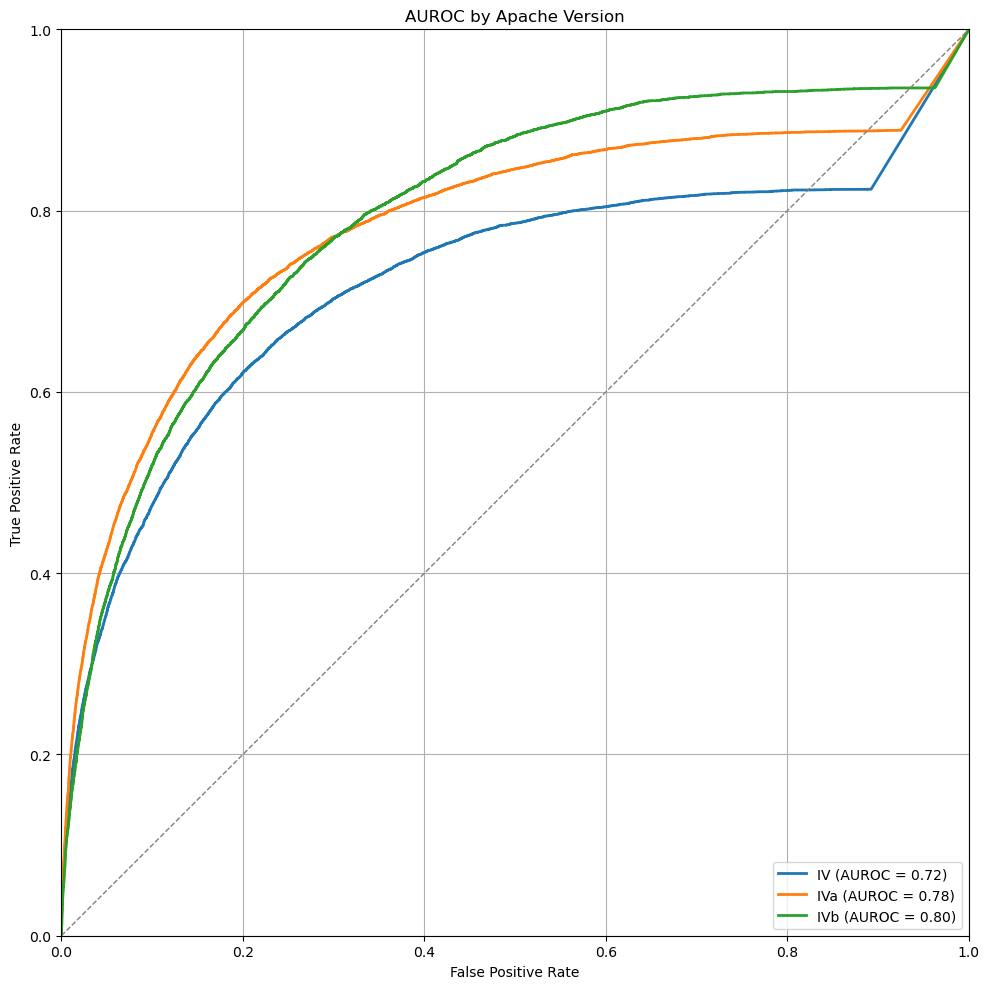

In [58]:

plt.figure(figsize=(10, 10))

for version in ['IV', 'IVa', 'IVb']:
    subset = df[df['Apache_Version'] == version]
    y_true = subset['mortality']
    y_scores = subset['predicted_hospital_mortality']
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)
    
    plt.plot(fpr, tpr, lw=2, label=f'{version} (AUROC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC by Apache Version')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


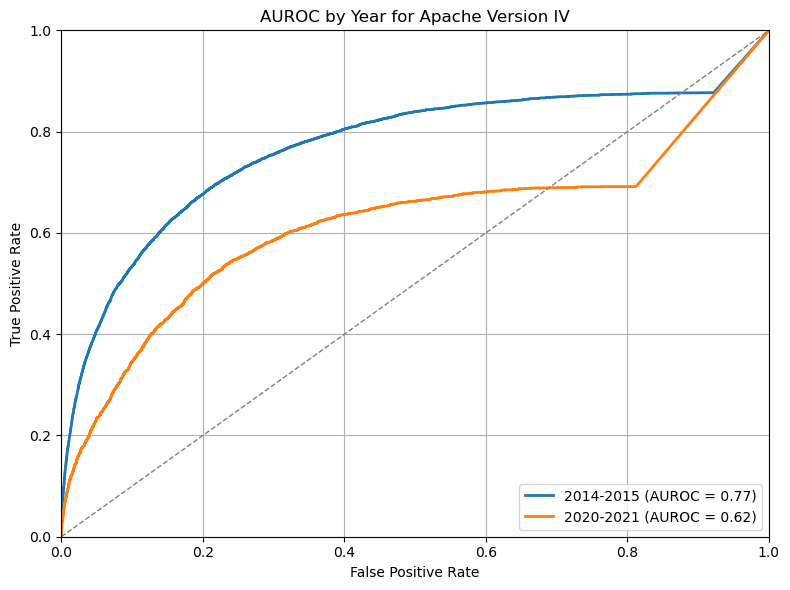

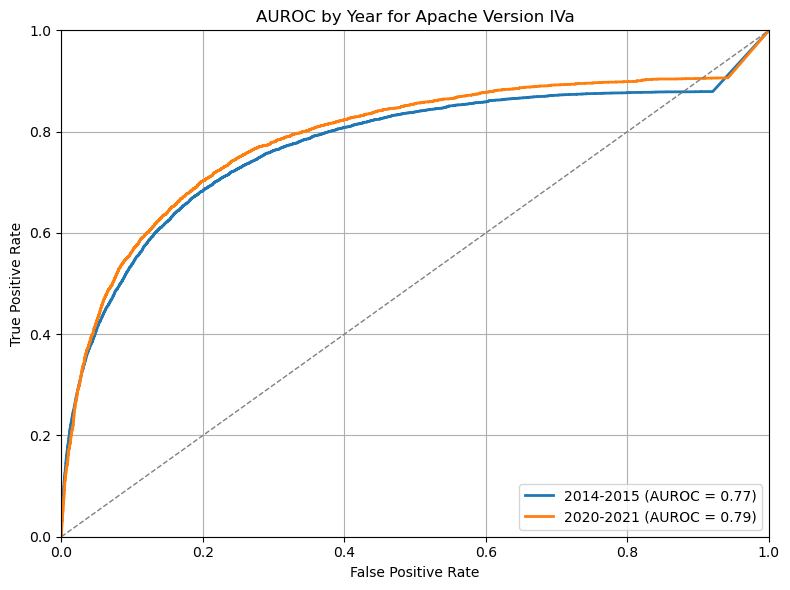

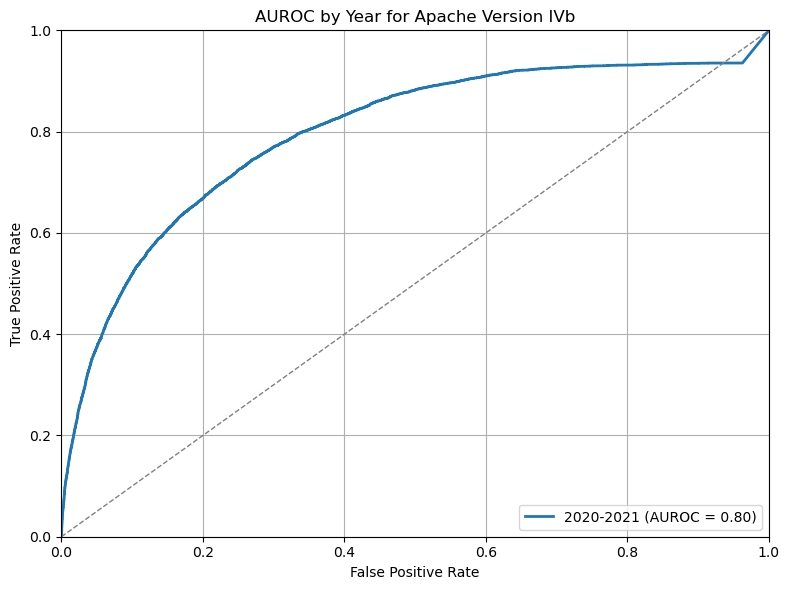

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

for version in ['IV', 'IVa', 'IVb']:
    plt.figure(figsize=(8, 6))
    subset_version = df[df['Apache_Version'] == version]

    for ethnicity in subset_version['set'].unique():
        subset = subset_version[subset_version['set'] == ethnicity]
        y_true = subset['mortality']
        y_score = subset['predicted_hospital_mortality']

        if len(y_true.unique()) < 2:
            continue  # Skip if only one class is present

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, lw=2, label=f'{ethnicity} (AUROC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUROC by Year for Apache Version {version}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


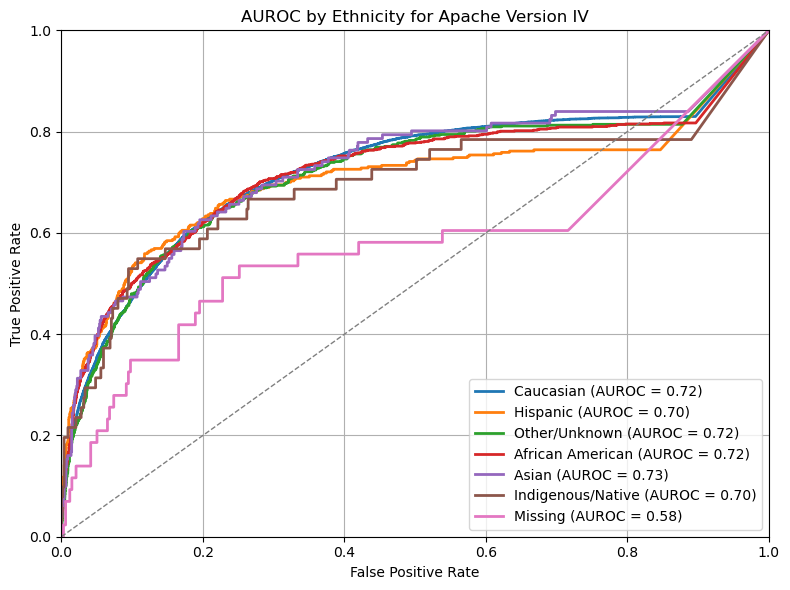

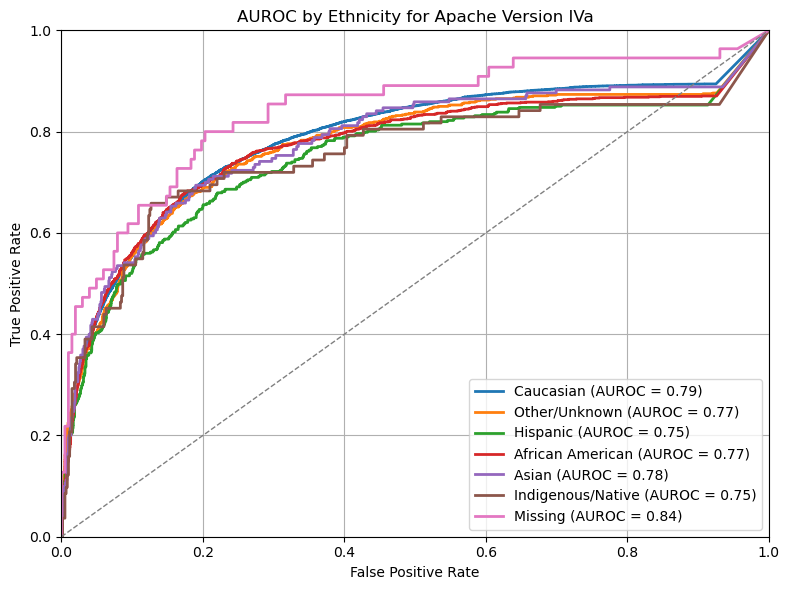

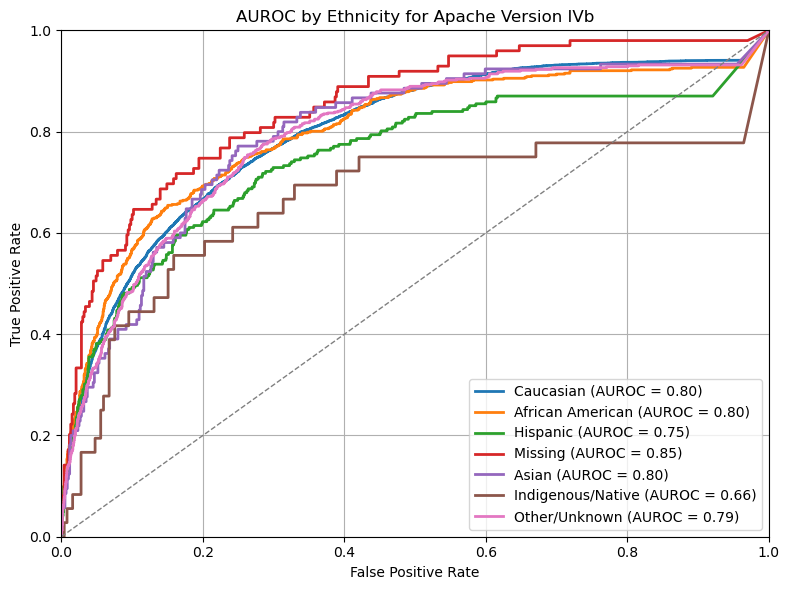

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

for version in ['IV', 'IVa', 'IVb']:
    plt.figure(figsize=(8, 6))
    subset_version = df[df['Apache_Version'] == version]

    for ethnicity in subset_version['ethnicity'].unique():
        subset = subset_version[subset_version['ethnicity'] == ethnicity]
        y_true = subset['mortality']
        y_score = subset['predicted_hospital_mortality']

        if len(y_true.unique()) < 2:
            continue  # Skip if only one class is present

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, lw=2, label=f'{ethnicity} (AUROC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUROC by Ethnicity for Apache Version {version}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<Figure size 800x600 with 0 Axes>

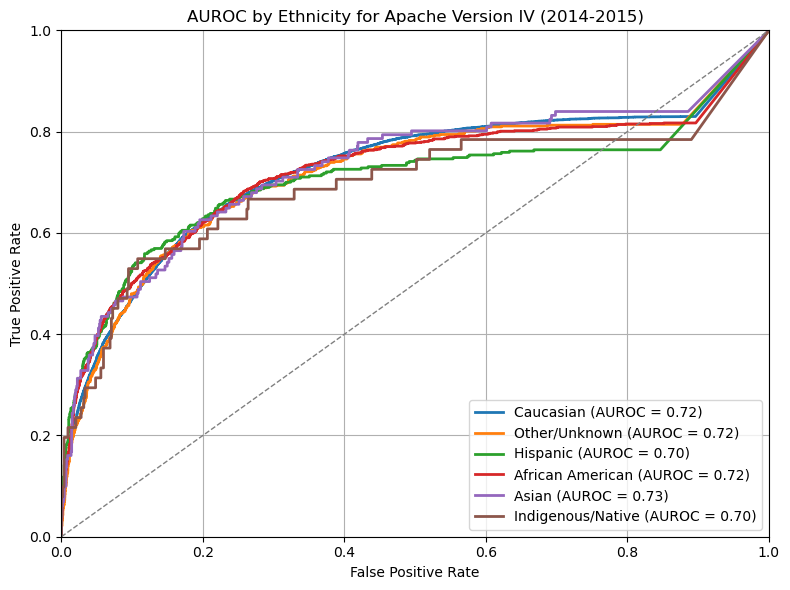

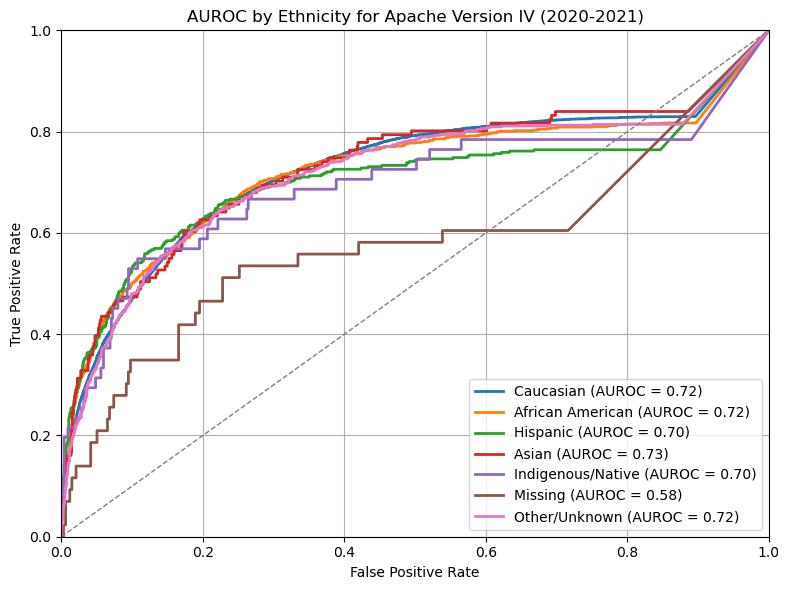

<Figure size 800x600 with 0 Axes>

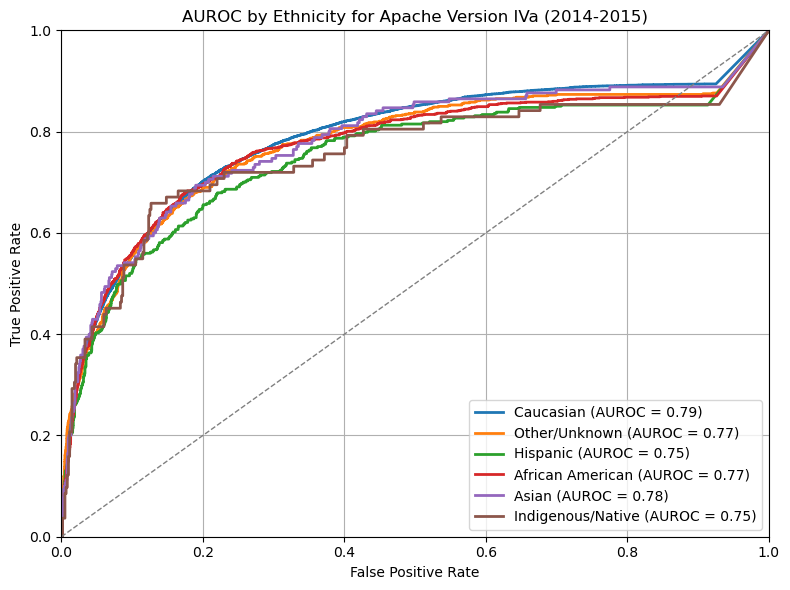

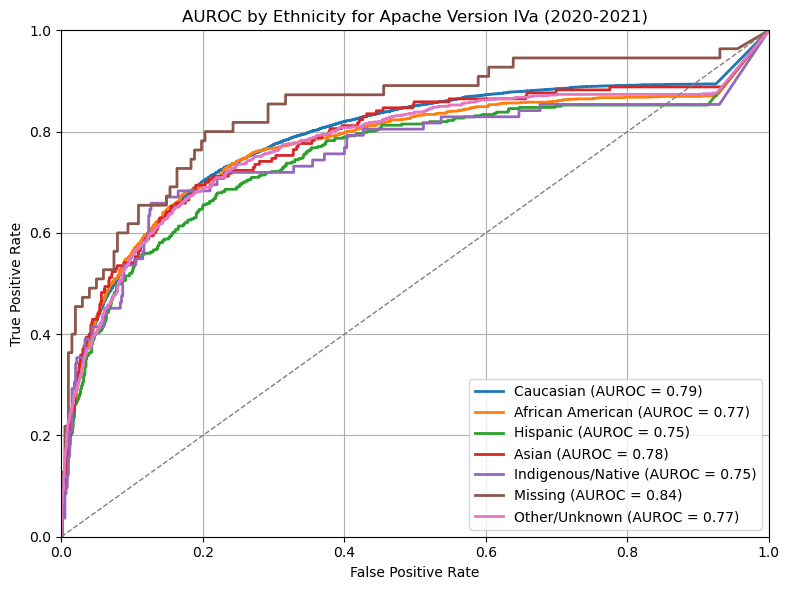

<Figure size 800x600 with 0 Axes>

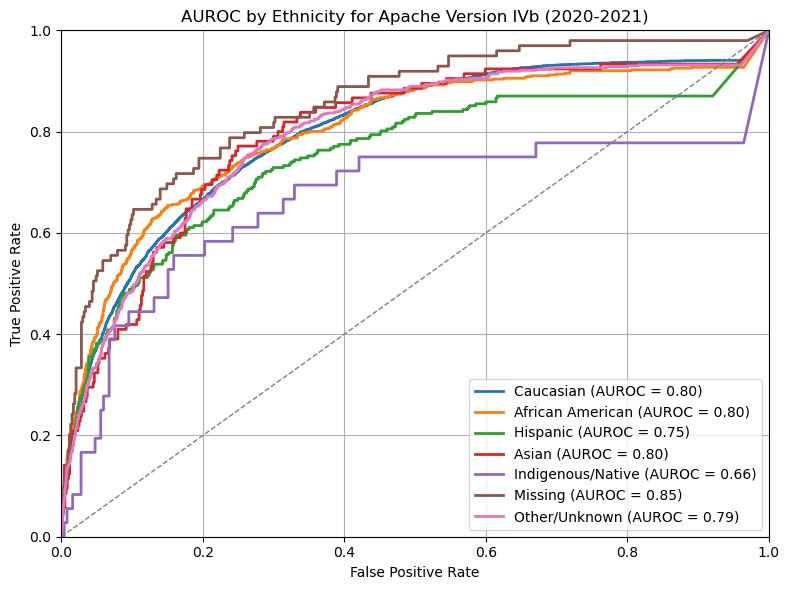

In [62]:
for version in ['IV', 'IVa', 'IVb']:
    plt.figure(figsize=(8, 6))
    subset_version = df[df['Apache_Version'] == version]
    
    for sets in subset_version['set'].unique():
        plt.figure(figsize=(8, 6))
        subset_set = df[df['set'] == sets]
        
        for ethnicity in subset_set['ethnicity'].unique():
            subset = subset_version[subset_version['ethnicity'] == ethnicity]
            y_true = subset['mortality']
            y_score = subset['predicted_hospital_mortality']
    
            if len(y_true.unique()) < 2:
                continue  # Skip if only one class is present
    
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = roc_auc_score(y_true, y_score)
            plt.plot(fpr, tpr, lw=2, label=f'{ethnicity} (AUROC = {auc_score:.2f})')
    
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'AUROC by Ethnicity for Apache Version {version} ({sets})')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [95]:
df['set'].unique()

array(['2014-2015', '2020-2021'], dtype=object)

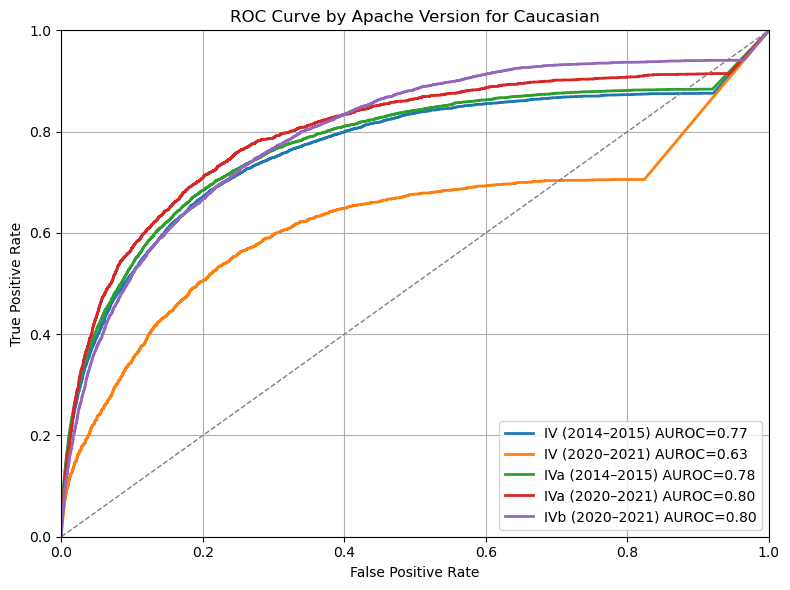

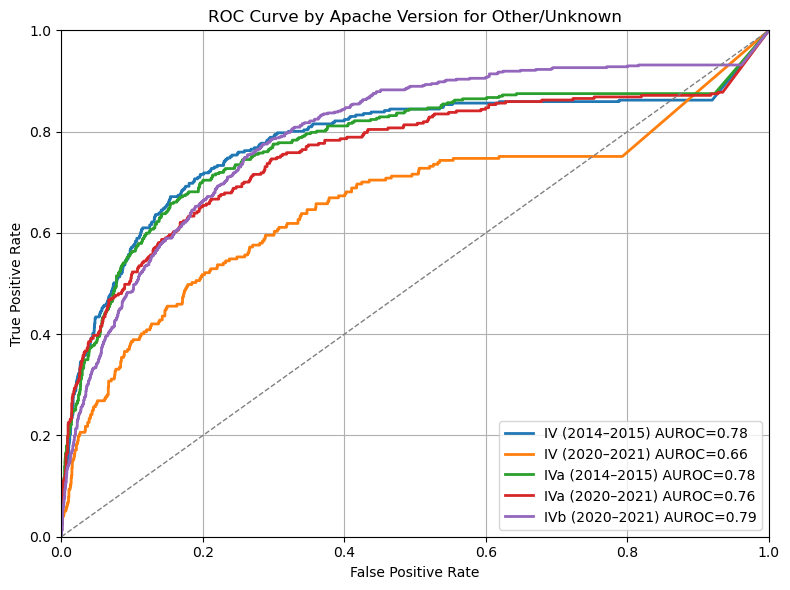

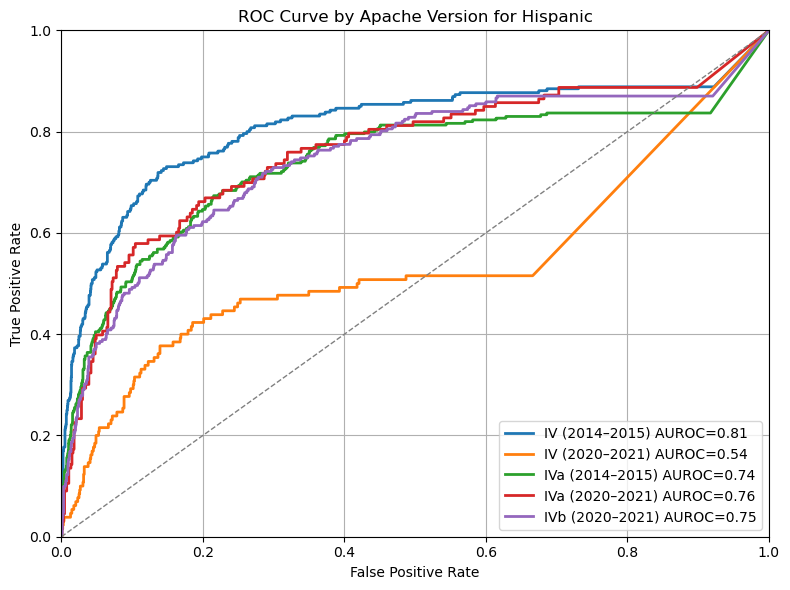

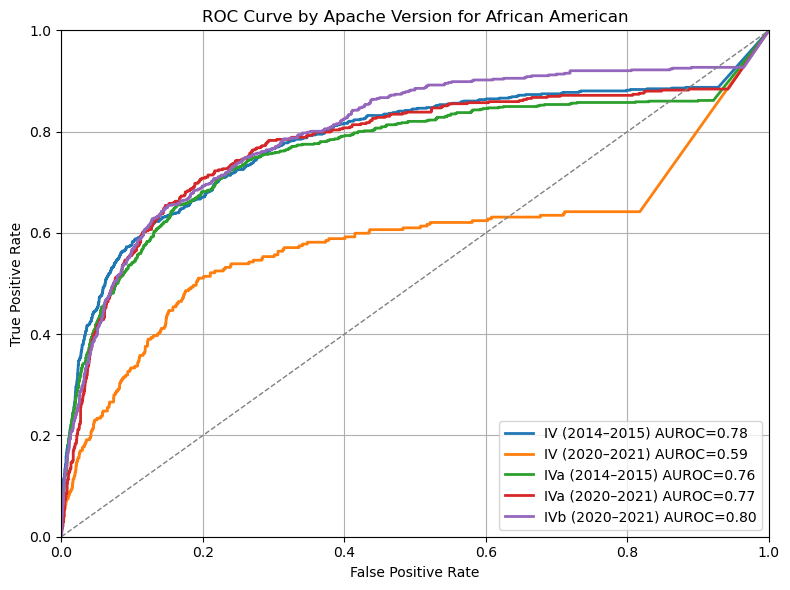

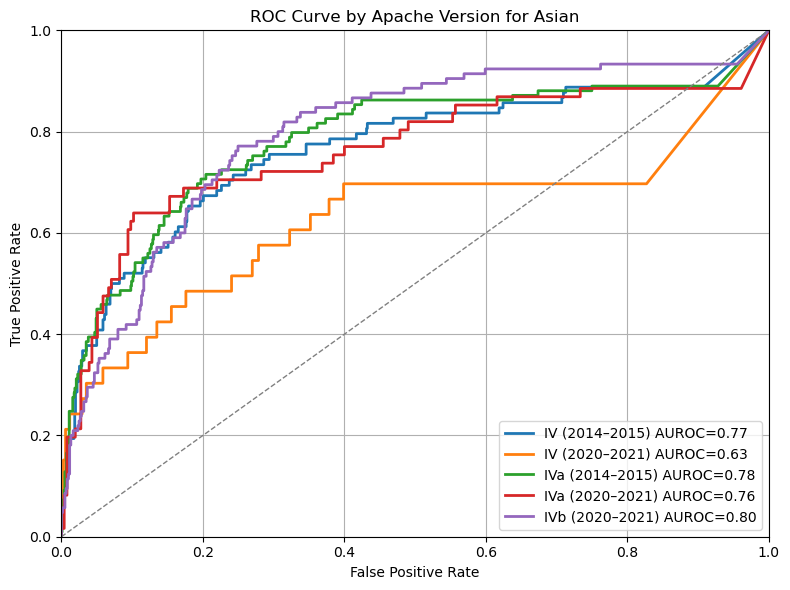

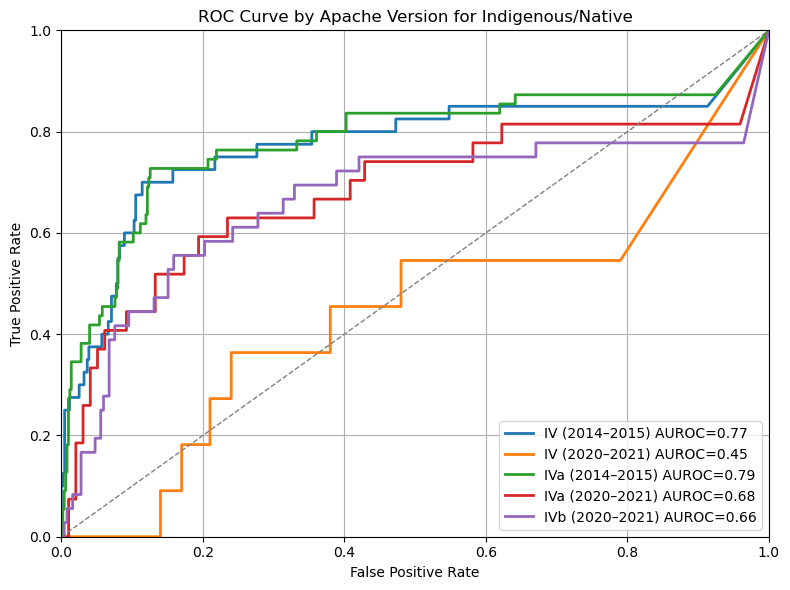

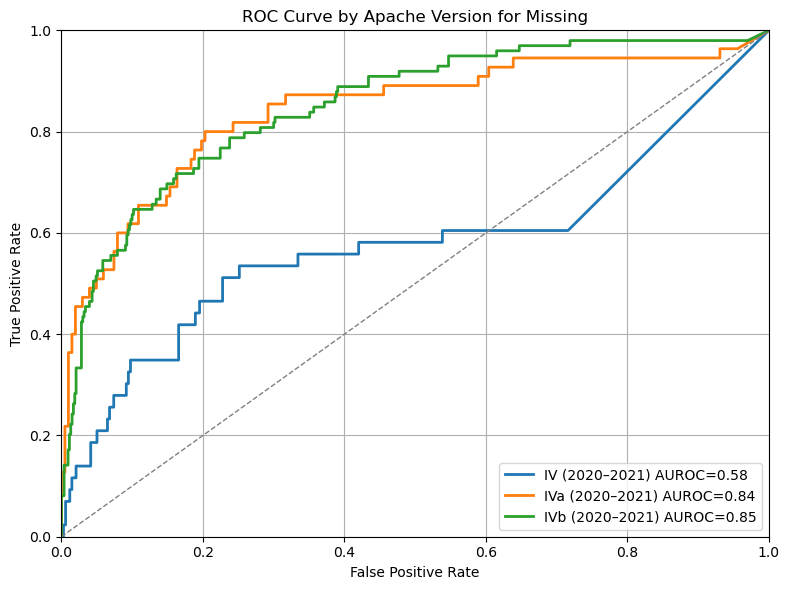

In [97]:

# Define year groups
year_groups = {
    "2014–2015": [2014, 2015],
    "2020–2021": [2020, 2021]
}

# Get all unique ethnicities
for ethnicity in df['ethnicity'].dropna().unique():
    plt.figure(figsize=(8, 6))
    
    for version in ['IV', 'IVa', 'IVb']:
        for group_name, years in year_groups.items():
            # Filter data
            subset = df[
                (df['ethnicity'] == ethnicity) &
                (df['Apache_Version'] == version) &
                (df['Discharge_Year'].isin(years))
            ]
            
            y_true = subset['mortality']
            y_score = subset['predicted_hospital_mortality']
            
            if len(y_true.unique()) < 2:
                continue  # Cannot compute ROC with one class only
            
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc = roc_auc_score(y_true, y_score)
            
            plt.plot(
                fpr, tpr,
                label=f'{version} ({group_name}) AUROC={auc:.2f}',
                lw=2
            )

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve by Apache Version for {ethnicity}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
